General Link: https://langchain-ai.github.io/langgraph/how-tos/#how-to-guides

## **Pydantic**

Link: https://langchain-ai.github.io/langgraph/how-tos/state-model/#how-to-use-pydantic-model-as-graph-state

Pydantic is a Python package that can offer simple data validation and manipulation. It was developed to improve the data validation process for developers. Indeed, Pydantic is an API for defining and validating data that is flexible and easy to use, and it integrates seamlessly with Python's data structures

Both `TypedDict` and **Pydantic** provide ways to define structured data in Python, but they serve different purposes and have key differences in functionality.


**1. TypedDict (from `typing`)**
- Introduced in Python 3.8.
- Used for defining dictionary-like structures with type hints.
- Does **not** provide runtime validation or type conversion.
- Primarily for static type checking (e.g., with `mypy`).

**Example of `TypedDict`**

In [9]:
from typing import TypedDict

class UserDict(TypedDict):
    id: int
    name: str
    age: int

# Creating a valid dictionary
user: UserDict = {"id": 1, "name": "Alice", "age": 30}

# This works but no runtime validation
user_invalid: UserDict = {"id": "abc", "name": "Alice", "age": 30}  # No error at runtime, but mypy will complain

print(user)
print(user_invalid)

{'id': 1, 'name': 'Alice', 'age': 30}
{'id': 'abc', 'name': 'Alice', 'age': 30}


✅ **Pros**:  
- Simple and lightweight.
- Works well for type checking in tools like `mypy`. 
 
❌ **Cons**:  
- No runtime validation.  
- No data parsing or transformation.  

**2. Pydantic (`BaseModel`)**
- Provides **runtime validation** and **type conversion**.
- Raises validation errors for incorrect types.
- Supports **default values, nested models, environment variables**, and more.
- Ideal for use cases like **API request validation** (e.g., with FastAPI).

**Example of `Pydantic`**

In [10]:
from pydantic import BaseModel

class User(BaseModel):
    id: int
    name: str
    age: int

# Valid input with automatic type conversion
user = User(id="1", name="Alice", age="30")  # Converts str to int automatically
print(user)

# Invalid input raises an error
try:
    user_invalid = User(id="abc", name="Alice", age="30")  # Raises a validation error
except Exception as e:
    print(e)

id=1 name='Alice' age=30
1 validation error for User
id
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='abc', input_type=str]
    For further information visit https://errors.pydantic.dev/2.10/v/int_parsing


✅ **Pros**:  
- **Runtime validation** and automatic type conversion.  
- Provides **detailed error messages**.  
- Supports **JSON serialization** and **environment variables**.  

❌ **Cons**:  
- Slightly heavier than `TypedDict` in terms of performance.  
- Requires installing `pydantic` (`pip install pydantic`). 

**Key Differences Summary**

| Feature           | TypedDict                 | Pydantic (BaseModel) |
|------------------|-------------------------|----------------------|
| **Purpose**      | Type hinting for dicts   | Data validation & modeling |
| **Runtime Validation** | ❌ No  | ✅ Yes |
| **Type Conversion** | ❌ No  | ✅ Yes |
| **Nested Models** | 🚫 Limited  | ✅ Yes (supports nested Pydantic models) |
| **Performance** | ✅ Faster (no runtime checks)  | ⏳ Slightly slower (runtime validation) |
| **Use Case** | Static type checking with `mypy` | Data validation, API schemas (FastAPI), config management |



**Which One Should You Use?**
- Use **`TypedDict`** when you only need **type hints** and **static type checking** (no runtime validation).  
- Use **Pydantic** when you need **runtime validation, type conversion, and structured data modeling** (e.g., API validation, parsing JSON data).  

For applications requiring **strict data validation (like invoices, API requests, and config settings)**, **Pydantic** is the better choice. 🚀

In [1]:
from typing_extensions import TypedDict

class State(TypedDict):
    xyz:str
    abc:str

In [2]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

from pydantic import BaseModel

# The overall state of the graph (this is the public state shared across nodes)
class OverallState(BaseModel):
    a: str

def node(state:OverallState):
    return {"a":"Hi I am Krish"}

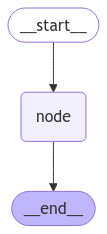

In [4]:
from IPython.display import Image, display

# Build the state graph
builder = StateGraph(OverallState)
builder.add_node(node)  # node_1 is the first node

builder.add_edge(START, "node")  # Start the graph with node_1
builder.add_edge("node", END)  # End the graph after node_1

graph = builder.compile()

# Show workflow
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
graph.invoke({"a":"Hello"})

{'a': 'Hi I am Krish'}

In [6]:
try:
    graph.invoke({"a":123})  #should be a string
except Exception as e:
    print("Exception was raised because a value iss integer")

Exception was raised because a value iss integer


## **Multiple Nodes- Run time validation**

Run-time validation will also work in a multi-node graph. In the example below bad_node updates a to an integer.

Because run-time validation occurs on inputs, the validation error will occur when ok_node is called (not when bad_node returns an update to the state which is inconsistent with the schema).

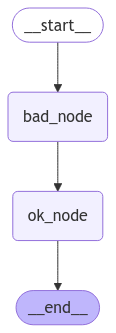

In [7]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from IPython.display import Image, display

from pydantic import BaseModel


class OverallState(BaseModel):
    a:str

def bad_node(state: OverallState):
    return {
        "a": 123  # Invalid
    }

def ok_node(state:OverallState):
    return {"a":"goodbye"}

# Build the state graph
builder = StateGraph(OverallState)
builder.add_node(bad_node)
builder.add_node(ok_node)
builder.add_edge(START, "bad_node")
builder.add_edge("bad_node", "ok_node")
builder.add_edge("ok_node", END)
graph = builder.compile()

# Show workflow
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
# Test the graph with a valid input
try:
    graph.invoke({"a": "krish"})
except Exception as e:
    print("An exception was raised because bad_node sets `a` to an integer.")
    print(e)

An exception was raised because bad_node sets `a` to an integer.
1 validation error for OverallState
a
  Input should be a valid string [type=string_type, input_value=123, input_type=int]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type


# **Workflows and Agents**


## **1) Prompt Chaining**

Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks on any intermediate steps to ensure that the process is still on track.

**When to use this workflow:**

This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

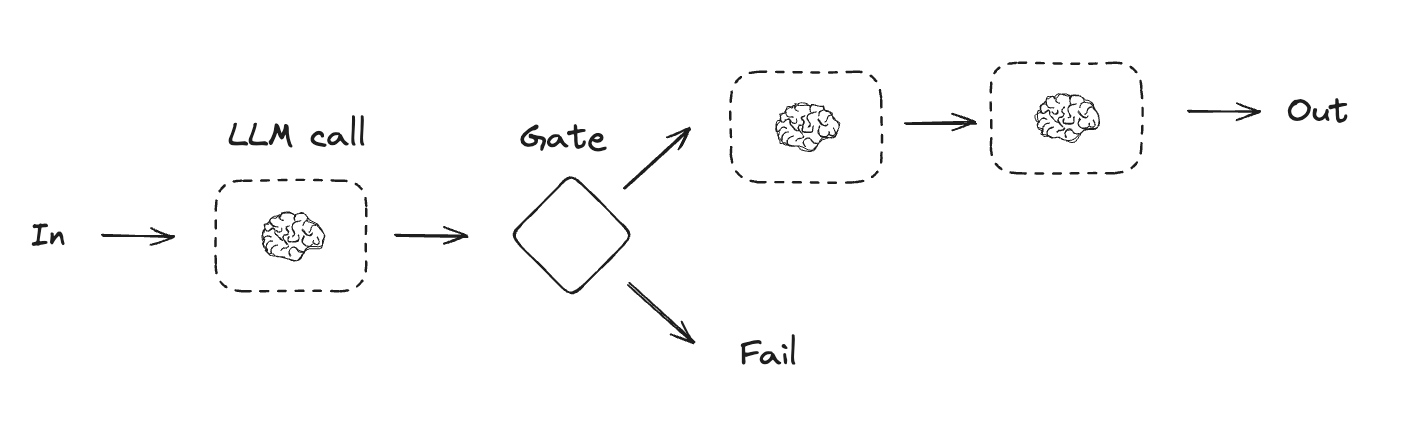

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

# Define LLM
llm=ChatGroq(model="qwen-2.5-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.00368118, 'queue_time': 0.235944402, 'total_time': 0.05368118}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-eb06c839-763b-4621-802a-d3d6c9c5617d-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

In [4]:
result.content

'Hello! How can I assist you today?'

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

In [ ]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

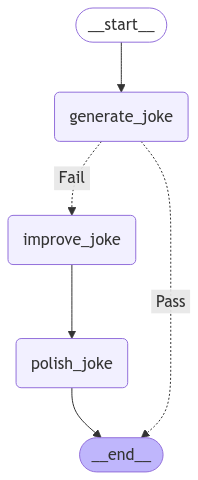

In [ ]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges("generate_joke",check_punchline,{"Fail":"improve_joke","Pass":END})
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [12]:
# Invoke
state = chain.invoke({"topic": "cats"})

In [13]:
state

{'topic': 'cats',
 'joke': "Why don't cats play poker in the wild? Because there are too many cheetahs!",
 'improved_joke': 'Why don\'t cats play poker in the wild? Because there are too many cheetahs, and every game ends with a "spots" decision!',
 'final_joke': 'Why don\'t cats play poker in the wild? Because there are too many cheetahs, and every game ends with a "spots" decision! But the real reason? One clever cat installed a kitty-cam, turning every poker night into an unintended reality show for the entire jungle, where the biggest bet was who would be the next star of "Poker in the Paws."'}

In [14]:
state['improved_joke']

'Why don\'t cats play poker in the wild? Because there are too many cheetahs, and every game ends with a "spots" decision!'

In [15]:
state['final_joke']

'Why don\'t cats play poker in the wild? Because there are too many cheetahs, and every game ends with a "spots" decision! But the real reason? One clever cat installed a kitty-cam, turning every poker night into an unintended reality show for the entire jungle, where the biggest bet was who would be the next star of "Poker in the Paws."'

## **2) Parallelization**

**With parallelization, LLMs work simultaneously on a task:**

LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, parallelization, manifests in two key variations: Sectioning: Breaking a task into independent subtasks run in parallel. Voting: Running the same task multiple times to get diverse outputs.

**When to use this workflow:**

Parallelization is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.

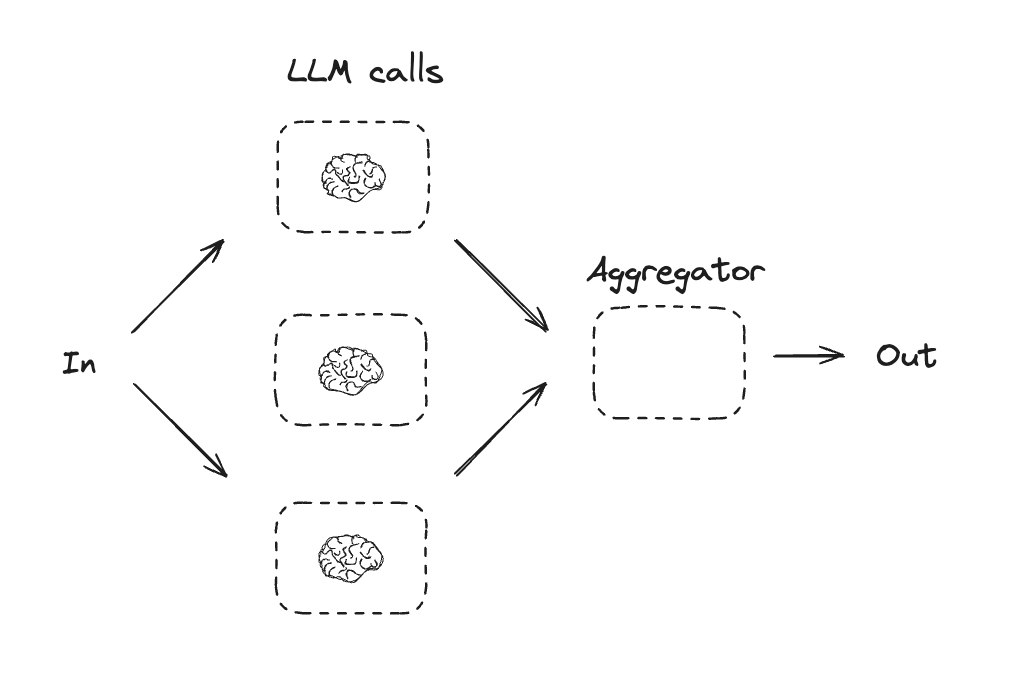

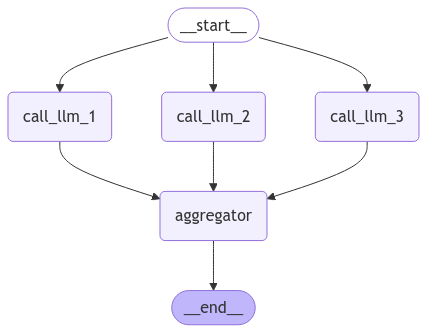

Here's a story, joke, and poem about cats!

STORY:
In a small, sunlit town nestled between rolling hills and whispering woods, there lived a community of cats unlike any other. These were not your average felines. Each one had a unique personality and a distinct purpose that made them cherished members of the town.

At the heart of the town was a cozy, brightly painted feline café called "The Pawfect Spot." This was more than a café; it was a hub where all the cats gathered to exchange stories, share meals, and plan adventures. The café was run by a wise and gentle tabby named Oliver. He was the heart of the community, always ready with a warm smile and a cup of milk to brighten anyone’s day.

One of the town's most beloved residents was a sleek black cat named Shadow. Shadow was the town's detective, solving mysteries that befuddled everyone else. His keen eyes and sharp mind made him the perfect fit for the role. One day, Shadow was called to investigate a case of missing fish from t

In [16]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

## **3) Routing**

Routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

**When to use this workflow:** 

Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.

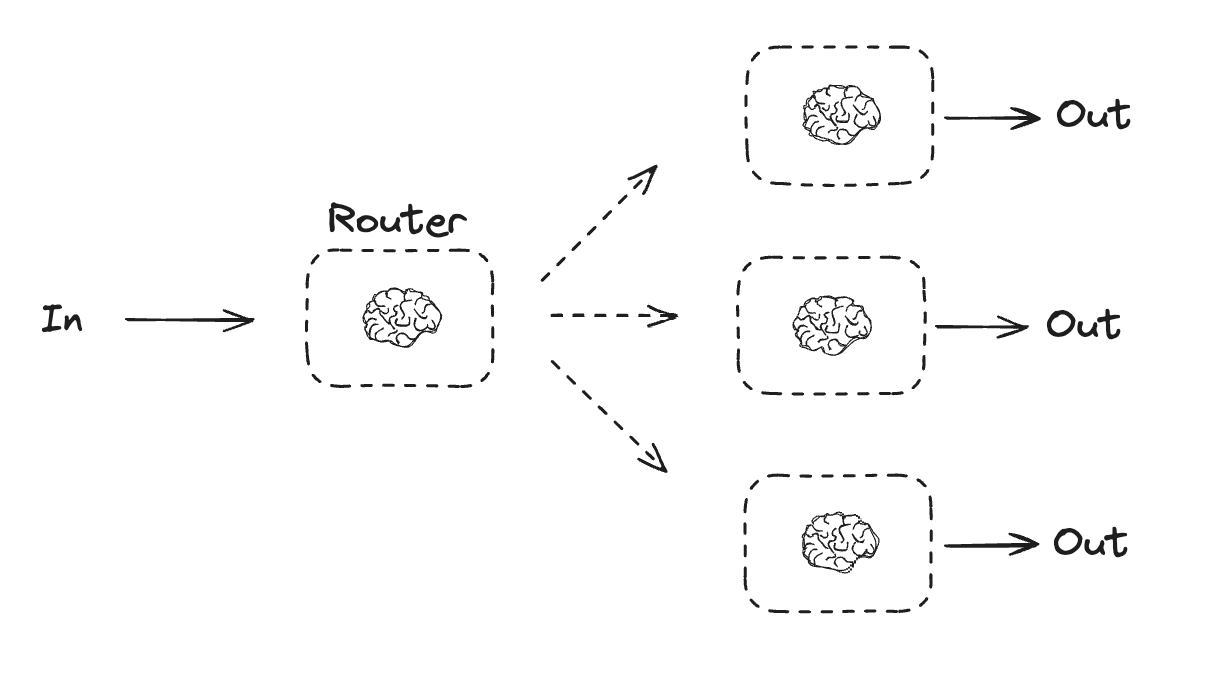

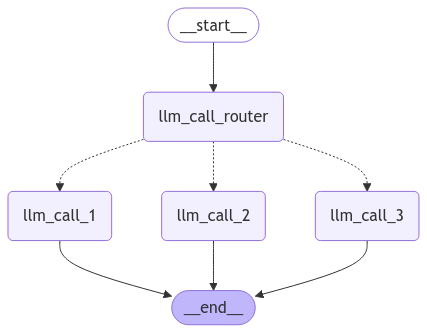

LLM call 2 is called
Why don't cats play poker in the wild? Because there are too many cheetahs!


In [17]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    print("LLM call 2 is called")

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

## **4) Orchestrator-Worker**
In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

**When to use this workflow:** 

This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

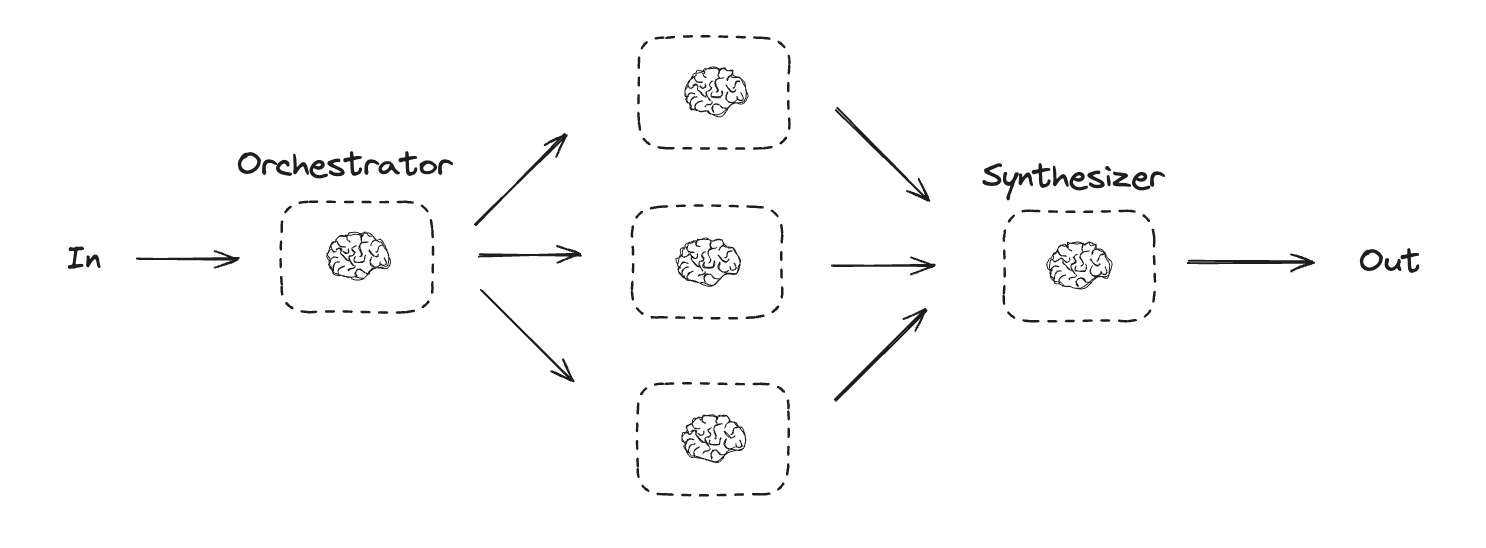

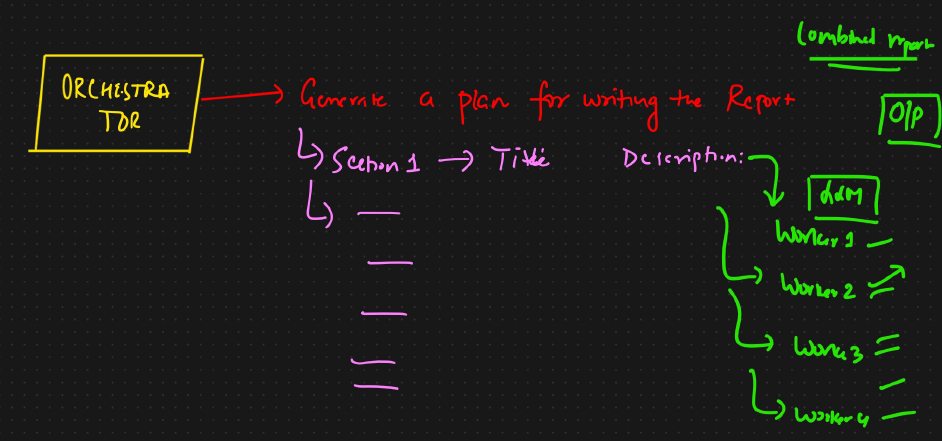

In [ ]:

from typing import Annotated, List
import operator
from pydantic import BaseModel, Field

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

### Creating Workers in LangGraph

Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. As you can see below, we iterate over a list of sections and Send each to a worker node. 

In [8]:
from langgraph.constants import Send
from typing_extensions import TypedDict

# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    print("Report Sections:",report_sections)

    return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


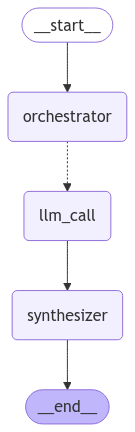

In [11]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [13]:
from langchain_core.messages import HumanMessage, SystemMessage

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on Agentic AI RAGs"})

from IPython.display import Markdown
Markdown(state["final_report"])

Report Sections: sections=[Section(name='Introduction', description='An introduction to Agentic AI RAGs, providing a brief history and background information.'), Section(name='Definition and Explanation', description='A detailed definition of Agentic AI RAGs and how they function.'), Section(name='Applications', description='Real-world applications of Agentic AI RAGs in various industries.'), Section(name='Advantages and Disadvantages', description='An analysis of the benefits and drawbacks of using Agentic AI RAGs.'), Section(name='Case Studies', description='An in-depth look at specific examples of Agentic AI RAGs in use.'), Section(name='Future Outlook', description='A discussion on the future trajectory of Agentic AI RAGs, including potential advancements and challenges.'), Section(name='Conclusion', description='A summary of key points and final thoughts on Agentic AI RAGs.')]


## Introduction

Agentic AI RAGs, or Retrieval-Augmented Generation systems, represent a significant advancement in the field of artificial intelligence, specifically in the domain of natural language processing (NLP) and information retrieval. The concept of Agentic AI RAGs builds upon the earlier developments in NLP, which include the evolution from rule-based systems to statistical models and, more recently, to deep learning architectures. 

The history of Agentic AI RAGs traces back to the broader advancements in machine learning, where the integration of retrieval mechanisms with generative models has been a focal point. Early systems were limited in their ability to understand and generate human language, often relying on a static database of responses. However, with the advent of neural network models, such as those utilizing transformers, AI systems began to exhibit a more nuanced understanding and generation of language.

Today, Agentic AI RAGs combine the strengths of retrieval-based and generative models, allowing for more accurate and contextually relevant responses. This integration enables AI systems to not only produce natural language outputs but also to leverage external knowledge bases effectively, enhancing their performance in various applications such as customer service, content creation, and knowledge management. The evolution of Agentic AI RAGs is a testament to the continuous progress and innovation in AI technology, aiming to bridge the gap between machine and human communication.

---

### Definition and Explanation

Agentic AI RAGs, or Retrieval-Augmented Generation systems, are advanced AI models designed to enhance the capabilities of language generation by integrating information retrieval processes. These systems are characterized by their ability to retrieve relevant information from a large corpus of documents and use it to improve the quality and accuracy of their generated responses. Agentic AI RAGs function through a two-step process: retrieval and generation.

1. **Retrieval**: In the first step, the system receives a query or input prompt. The AI then searches through a vast repository of pre-indexed documents to find the most relevant pieces of information that can be used to formulate a response. This retrieval process is typically powered by an efficient information retrieval mechanism that ranks documents based on their relevance to the input.

2. **Generation**: Once the relevant documents are retrieved, the AI uses this contextual information to generate a coherent and informative response. Unlike traditional language generation models that rely solely on their internal parameters to generate text, Agentic AI RAGs draw from external data to provide more accurate, detailed, and contextually relevant outputs.

The integration of retrieval and generation processes in Agentic AI RAGs allows these systems to overcome limitations in knowledge scope and context specificity. As a result, they can provide users with more reliable and comprehensive information, making these systems particularly valuable in applications requiring up-to-date and precise information, such as customer support, research assistance, and educational tools.

---

## Applications of Agentic AI RAGs in Various Industries

Agentic AI RAGs, or Retrieval-Augmented Generation systems, are revolutionizing industries by providing sophisticated solutions to complex problems. These systems leverage large language models to generate human-like text by incorporating information retrieval mechanisms that enhance their context-awareness and factual accuracy. Here are some real-world applications across various sectors:

### Healthcare

In healthcare, Agentic AI RAGs can provide personalized patient care by synthesizing patient data, medical literature, and clinical guidelines to assist doctors in making informed decisions. They can also support patient education by delivering detailed, context-specific information in a comprehensible format, thereby improving patient engagement and outcomes.

### Finance

The finance industry utilizes Agentic AI RAGs for risk assessment, fraud detection, and customer service. These systems can analyze vast amounts of financial data in real-time to predict market trends and manage investment portfolios effectively. Customer service bots powered by RAGs can handle inquiries with high accuracy, providing timely and relevant information to customers.

### Legal

Agentic AI RAGs in the legal field help in legal research by summarizing statutes, case laws, and legal documents, thereby saving time and improving efficiency. They can also draft legal documents and provide legal advice, enhancing the speed and quality of legal services.

### Retail

In retail, Agentic AI RAGs can enhance customer experience by providing personalized shopping recommendations and accurate product information. They can also assist in inventory management by predicting demand and optimizing stock levels, thereby reducing waste and improving sales.

### Education

Agentic AI RAGs can revolutionize education by creating personalized learning experiences. These systems can generate customized curricula based on the learning pace and style of students, providing explanations and examples that enhance understanding of difficult concepts.

### Customer Support

Customer support is another area where Agentic AI RAGs are making significant strides. They can handle a large volume of inquiries with a high degree of personalization, providing immediate and accurate responses. This not only improves customer satisfaction but also reduces the workload on human customer service representatives.

### Marketing

In marketing, Agentic AI RAGs can create data-driven content, such as personalized emails and blog posts, that resonate with target audiences. They can also analyze customer feedback and market trends to inform marketing strategies and improve campaign effectiveness.

Agentic AI RAGs are thus transforming industries by enabling more efficient, personalized, and data-driven decision-making processes. Their adaptability and effectiveness across a variety of applications highlight their potential to drive innovation and growth in the future.

---

### Advantages and Disadvantages

#### Advantages
1. **Efficiency and Speed**: Agentic AI RAGs (Retrieve and Generate) can process and retrieve information at a pace far exceeding human capabilities, enabling quick decision-making and problem-solving.
2. **Scalability**: These systems can be scaled up to handle vast amounts of data and multiple tasks simultaneously without a proportional increase in error rates, making them highly scalable.
3. **Personalization**: Agentic AI RAGs can be tailored to individual user needs, offering personalized experiences and recommendations based on user behavior and preferences.
4. **Error Reduction**: Once trained, these systems can reduce human errors common in repetitive or data-intensive tasks, leading to higher accuracy in outcomes.
5. **Accessibility**: Agentic AI RAGs can be deployed across a variety of platforms, making advanced analytics and insights accessible to a broader range of users, including non-technical users.

#### Disadvantages
1. **Data Dependency**: The performance of Agentic AI RAGs heavily depends on the quality and quantity of data available. Poor data quality can lead to inaccurate outputs.
2. **Privacy Concerns**: Handling large amounts of data can raise privacy issues, particularly if the data includes sensitive personal information. Ensuring data privacy and compliance with regulations can be challenging.
3. **Lack of Creativity**: While Agentic AI RAGs excel at data processing and retrieval, they lack the creativity and intuition that human intelligence offers, limiting their ability to generate innovative solutions.
4. **Implementation Costs**: The initial setup and ongoing maintenance of Agentic AI RAG systems can be costly, involving significant investment in technology and expertise.
5. **Ethical Issues**: There are ethical concerns regarding the use of AI, such as potential bias in data and algorithm design, which can lead to unfair or discriminatory outcomes.

---

### Case Studies

#### Case Study 1: Customer Support Enhancement

**Overview:**
In this case study, an Agentic AI RAG system was integrated into a customer support platform for a major e-commerce company. The system was designed to handle a wide range of customer inquiries, from simple product information to more complex support issues.

**Implementation:**
The Agentic AI RAG was trained using a combination of historical customer support data, product information, and user feedback. The AI was able to learn from ongoing interactions, improving its response accuracy and speed over time.

**Results:**
The implementation of the Agentic AI RAG led to a 30% reduction in customer wait time and a 25% improvement in customer satisfaction scores. The AI was able to resolve 40% of the customer issues without human intervention, allowing support staff to focus on more complex problems.

#### Case Study 2: Financial Advisory Services

**Overview:**
A financial services firm utilized an Agentic AI RAG to enhance its advisory services. The system was tasked with providing personalized investment advice to clients, using a combination of market data, historical trends, and individual client profiles.

**Implementation:**
The AI was trained on a vast dataset of financial market data and client interaction history. Machine learning algorithms were used to predict market movements and tailor recommendations to the risk tolerance and financial goals of individual clients.

**Results:**
Client satisfaction increased by 18%, and the firm reported a 15% rise in client engagement in financial planning services. The Agentic AI RAG also helped the firm to identify high-risk investments, reducing potential losses by 12%.

#### Case Study 3: Medical Diagnosis Support

**Overview:**
In the healthcare sector, an Agentic AI RAG was deployed to assist medical professionals in the diagnosis of complex medical conditions. The system was designed to analyze patient data, medical history, and symptoms to provide initial diagnostic suggestions.

**Implementation:**
The AI was trained on extensive medical databases, incorporating feedback from medical professionals to refine its diagnostic capabilities. The system aimed to provide a preliminary diagnosis to support doctors' decision-making processes.

**Results:**
The Agentic AI RAG assisted in the preliminary diagnosis of 1,200 cases, with a diagnostic accuracy of 89%. This preliminary analysis helped reduce the time to final diagnosis by 23% and increased the accuracy of initial diagnoses, thereby potentially improving patient outcomes.

These case studies demonstrate the versatility and effectiveness of Agentic AI RAGs in enhancing operational efficiency and decision-making across various industries.

---

### Future Outlook

The future trajectory of Agentic AI RAGs (Retrieval-Augmented Generation) is poised to revolutionize how information is processed and synthesized, leading to significant advancements in the capabilities and applications of AI systems. As the technology matures, we can expect improvements in the accuracy and relevance of information retrieval, enabling more sophisticated and context-aware interactions. Advances in natural language processing (NLP) and machine learning will likely result in more nuanced understanding and generation of language, enhancing the conversational abilities of RAGs.

However, the path forward is not without its challenges. Ethical considerations, such as the potential for misinformation and bias, will require robust frameworks for regulation and oversight. Ensuring data privacy and security in the face of sophisticated AI systems will be critical, particularly as RAGs are integrated into sensitive areas such as healthcare and finance. Additionally, the computational demands of training and maintaining large-scale RAG models will need to be addressed to make the technology more accessible and sustainable.

In the coming years, the integration of RAGs into existing technologies and the development of new applications will likely accelerate, driven by ongoing research and innovation. The adaptation of RAGs to handle multimodal data, including images and videos, could expand their utility across various industries, from education and entertainment to customer service and research. As these systems evolve, they will continue to play an increasingly integral role in enhancing human productivity and decision-making processes, shaping a future where AI is deeply embedded in our daily lives.

---

### Conclusion

Agentic AI RAGs, or Retrieval-Augmented Generation systems, represent a significant advancement in the field of artificial intelligence, blending the strengths of retrieval and generative models to enhance the accuracy and relevance of responses. By integrating a large corpus of knowledge through retrieval, these systems can generate more informed and contextually appropriate outputs. Key benefits include improved factual accuracy, reduced hallucinations in responses, and the ability to incorporate up-to-date information seamlessly.

However, the deployment of Agentic AI RAGs is not without its challenges. Issues such as bias in data, the complexity of system integration, and the need for ongoing refinement to maintain relevance and accuracy must be carefully managed. Furthermore, the ethical implications of AI systems that can generate content indistinguishable from human-authored material demand rigorous oversight and transparency.

In summary, Agentic AI RAGs offer transformative potential for applications ranging from customer service to academic research, provided that the associated risks are mitigated through robust governance and ethical considerations. As technology progresses, continued research and iterative development will be crucial to fully realize the benefits of these systems while minimizing potential harms.

In [14]:
# My Test
from langchain_core.messages import HumanMessage, SystemMessage

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a Blog on Support Vector Machine Algorithm"})

from IPython.display import Markdown
Markdown(state["final_report"])

Report Sections: sections=[Section(name='Introduction', description='An introduction to the concept of Support Vector Machine (SVM) algorithm, its purpose and importance in machine learning.'), Section(name='Basic Concepts', description='Explanation of key concepts such as hyperplanes, margins, support vectors, and the kernel trick.'), Section(name='Types of SVM', description='Discussion of different types of SVM including linear and non-linear SVMs.'), Section(name='Applications of SVM', description='Real-world applications of SVM algorithm in various fields such as finance, bioinformatics, etc.'), Section(name='Implementation', description='A step-by-step guide on how to implement SVM using a popular machine learning library such as scikit-learn in Python.'), Section(name='Advantages and Disadvantages', description='Overview of the pros and cons of using SVM.'), Section(name='Conclusion', description='Summary of the key points covered in the blog and the importance of SVM in the fiel

## Introduction

Support Vector Machine (SVM) is a powerful and versatile supervised machine learning model, primarily used for classification and regression tasks. The fundamental concept of SVM involves finding the hyperplane that best divides a dataset into distinct classes. This hyperplane, which maximizes the margin between different classes, is determined by support vectors, data points that are closest to the hyperplane and influence its position and orientation. SVMs are particularly effective in high-dimensional spaces and are versatile due to the ability to define different kernel functions that can handle both linear and non-linear data.

The importance of SVM in machine learning lies in its ability to achieve high accuracy while maintaining generalization on unseen data, thus reducing the risk of overfitting. SVMs perform exceptionally well in scenarios where the number of dimensions exceeds the number of samples, making them particularly useful in bioinformatics, text categorization, and image recognition. The algorithm’s strength in handling complex datasets with high dimensionality makes it a preferred choice for many real-world applications.

---

## Basic Concepts

Hyperplanes are linear decision boundaries that are used to separate different classes in a dataset. In a two-dimensional space, a hyperplane is a line that divides the space into two parts, each containing points of a different class. The goal in classification tasks, especially in support vector machines (SVMs), is to find the hyperplane that maximally separates the classes.

Margins are the distances between the hyperplane and the nearest data points of each class. In SVMs, the margin is defined as the distance between the hyperplane and the closest data points from each class, which are called support vectors. The objective of an SVM is to maximize this margin, as a larger margin generally leads to better generalization to unseen data.

Support vectors are the data points that are closest to the hyperplane and define the margin's boundaries. They are critical to the definition of the hyperplane and are the only data points that influence its placement. This means that the position of the hyperplane is determined solely by the support vectors, making SVMs a powerful tool for datasets with many irrelevant features.

The kernel trick is a method used in SVMs to solve non-linear classification problems. It involves transforming the original input space into a higher-dimensional space where a linear hyperplane can be used to separate the classes. This transformation is performed using a kernel function, which computes the inner product in the high-dimensional space without explicitly performing the transformation. Common kernel functions include the linear kernel, polynomial kernel, and the radial basis function (RBF) kernel.

---

### Types of SVM

Support Vector Machines (SVMs) can be categorized into linear and non-linear types based on their ability to handle different types of data distributions. 

- **Linear SVM**: This type of SVM is used for classification when data is linearly separable. It finds the optimal hyperplane that maximally separates the two classes. The decision boundary is a straight line (in 2D) or a flat plane (in 3D), which can be described by a linear equation.

- **Non-linear SVM**: When data is not linearly separable, non-linear SVMs use a kernel trick to transform the input space into a higher-dimensional space where a linear separation is possible. Commonly used kernels include the polynomial kernel, radial basis function (RBF) kernel, and sigmoid kernel. Each kernel has its own properties and is suitable for different types of data distributions. The choice of kernel and its parameters can significantly affect the performance of the SVM.

---

### Applications of SVM

Support Vector Machines (SVMs) are widely utilized across various sectors owing to their robustness and effectiveness in handling complex datasets. In finance, SVMs are employed for credit risk assessment and algorithmic trading by predicting market trends and identifying high-risk transactions. In bioinformatics, SVMs contribute significantly to gene expression analysis, protein classification, and disease diagnosis by accurately classifying and predicting patterns in biological data. SVMs are also pivotal in the field of image recognition, where they are used for object detection and face recognition, enhancing security systems and digital media applications. These diverse applications underscore SVMs' versatility and their critical role in advancing technological and scientific research.

---

## Implementation

### Step 1: Import Necessary Libraries
First, import the necessary Python libraries, including `scikit-learn` for the SVM model and other utilities.

```python
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
```

### Step 2: Load and Prepare Data
Load your dataset into a format that can be used by scikit-learn, typically a NumPy array or a pandas DataFrame. Split the dataset into features (`X`) and labels (`y`).

```python
X = np.array([[1,2],[2,3],[3,4],[4,5]])  # Example feature set
y = np.array([0, 0, 1, 1])  # Example labels
```

### Step 3: Split Data into Training and Testing Sets
Split the data into training and testing datasets to evaluate the performance of the model.

```python
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
```

### Step 4: Create and Train the SVM Model
Create an SVM classifier, specifying the kernel type and other parameters as needed. Then, train the model using the training data.

```python
clf = svm.SVC(kernel='linear')  # Linear kernel
clf.fit(X_train, y_train)
```

### Step 5: Make Predictions
Use the trained model to make predictions on the testing data.

```python
y_pred = clf.predict(X_test)
```

### Step 6: Evaluate the Model
Evaluate the performance of the model by comparing the predicted values with the actual values from the test set.

```python
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
```

### Step 7: Analyze and Iterate
Analyze the performance of your model and iterate by adjusting parameters, using different kernels, or preprocessing the data differently to improve the accuracy or other performance metrics.

---

### Advantages and Disadvantages

**Advantages:**
- **Effectiveness in High Dimensional Spaces:** Support Vector Machines (SVM) are particularly effective in high-dimensional spaces, making them suitable for datasets with a large number of features.
- **Memory Efficiency:** SVMs utilize a subset of training points (support vectors) in the decision function, which makes the model memory efficient.
- **Versatility with Kernels:** SVMs can use different types of kernel functions (linear, polynomial, RBF, etc.) which allows them to solve both linear and non-linear problems.
- **Generalization Strength:** Despite the fact that they are high bias models (they attempt to fit the data as closely as possible), SVMs have strong generalization capabilities, meaning they perform well on unseen data.

**Disadvantages:**
- **Computational Complexity:** The training time of SVMs is higher compared to other algorithms like decision trees or linear regression. For large datasets, this can be a limiting factor.
- **Non-Probabilistic Outputs:** SVMs do not provide probability estimates directly, only confidence scores. These probabilities have to be estimated using an additional procedure.
- **Sensitive to Parameter Selection:** The performance of SVMs is highly dependent on the selection of parameters (like the type of kernel and regularization parameter C). Finding the right parameters often requires a lot of trial and error.
- **Interpretability:** SVM models, especially with non-linear kernels, can be complex and less interpretable compared to simpler models like logistic regression.

---

### Conclusion

This blog has covered the essential aspects of Support Vector Machines (SVM), including their foundational principles, how they operate to classify data, and their unique advantages in handling high-dimensional spaces and non-linear data through the use of kernels. It has also highlighted practical applications of SVMs across various domains, showcasing their versatility and effectiveness.

The importance of SVM in the field of machine learning cannot be overstated. SVMs provide robust solutions to complex classification and regression problems, particularly where data is not easily separable. Their ability to generalize well from a limited number of samples makes them invaluable in real-world scenarios where data might be scarce or noisy. As such, understanding and utilizing SVMs is crucial for anyone involved in machine learning, whether in research or industry.

## **5) Evaluator-optimizer (Automatic)**

In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.

**When to use this workflow:** 

This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.

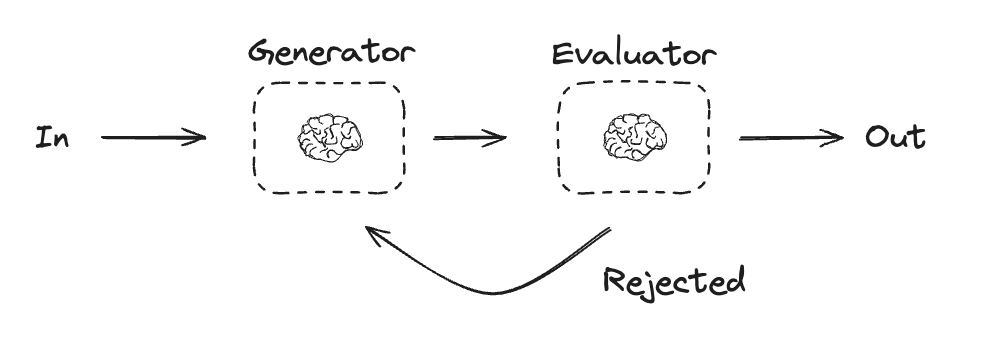

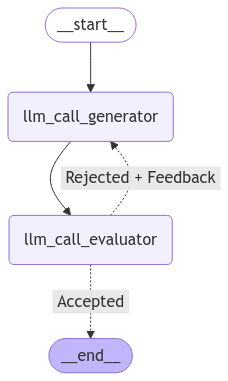

Why don't cats play poker in the wild? Because there are too many cheetahs!


In [23]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])